<a href="https://colab.research.google.com/github/ChingXi/Credit-Card-Fraud-Detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Credit Card Fraud Detection**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

Features V1, V2, … V28 are masked and are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount.

Class = 1 = Fraud

Class = 0 = Not Fraud

##**PCA Transformation**

**What is PCA?**

Principal Component Analysis is a dimensionality reduction and machine learning methods used to simplifying large dataset into smaller dataset while still maintaining pattern and trends.

From this dataset, we have principal components V1-V28. There may be a lot more features before PCA that we do not know about, however, having lesser dimension while maintaining data integrity is ideal.(In computational power, ease of visualization) Ranked from most important V1 to least important V28.

Each principal components comes with a "loading" or weight. The further the weight is from 0, the higher the importance between principal component and variables.

**What is a dimension?**

Let's illustrate this with an example.
Scalar = 1 Dimension
Vector = 2 Dimension
Tensors = 3 Dimension ++

With each increment in dimension, we are able to encapsulate more information.

E.g. 1 Dimension Greyscale (0-255) to 3 Dimension RGB(255,255,255), we are able to represent more colours.

##**Precision vs Recall**

Precision measures the proportion of true positive predictions among all positive predictions. It's calculated as TP / (TP + FP), where TP is the number of true positives and FP is the number of false positives.

Precision is used when the cost of false positives is high. In fraud detection, for example, falsely flagging legitimate transactions as fraudulent can inconvenience users and damage trust. Therefore, high precision is desirable to minimize false positives.

___

Recall measures the proportion of true positive predictions among all actual positive instances. It's calculated as TP / (TP + FN), where TP is the number of true positives and FN is the number of false negatives.

Recall is used when the cost of false negatives is high. In medical diagnostics, missing a diagnosis for a serious condition can have severe consequences. Therefore, high recall is desirable to minimize false negatives.

##**Accuracy**

Why is accuracy not a meaningful metric of measurement in imbalanced dataset?

Accuracy measures the proportion of correct predictions (both true positives and true negatives) among all predictions. It's calculated as (TP + TN) / (TP + TN + FP + FN), where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

While accuracy is a common metric, it's not always suitable for unbalanced datasets, where one class is much more prevalent than the other. In such cases, a high accuracy score can be misleading because a classifier might achieve high accuracy by simply predicting the majority class for all instances. This is particularly problematic in fraud detection, where the fraud class is often highly imbalanced compared to the non-fraud class.

In [ ]:
import os
import math
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d mlg-ulb/creditcardfraud

 74% 49.0M/66.0M [00:00<00:00, 174MB/s]
100% 66.0M/66.0M [00:00<00:00, 182MB/s]


In [ ]:
!unzip creditcardfraud.zip  && rm creditcardfraud.zip

Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          


In [ ]:
data = pd.read_csv('creditcard.csv')

In [ ]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


With PCA, we are able to tell that Principal Component V1 with larger absolute loadings captures a stronger relationship with the original data compared to V2. And V2 to V3 and subsequently to V28.

##**Exploratory Data Analysis**

In this stage, we try to understand the data through compartmentalization and visualization. We want to poke and prod the data to discover any obvious trend of features contributing to fraud identification.

In [ ]:
data.shape

(284807, 31)

In [ ]:
types = data['Class'].value_counts()
types

Class
0    284315
1       492
Name: count, dtype: int64

In [ ]:
data.isna().sum().max()

0

In [ ]:
data.reset_index(inplace=True)

In [ ]:
data.describe()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,142403.000000,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,82216.843396,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,71201.500000,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,142403.000000,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,213604.500000,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,284806.000000,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
fraud_data = data[data["Class"]==1]
non_fraud_data = data[data["Class"]==0]

In [ ]:
fraud_data.shape,non_fraud_data.shape

((492, 32), (284315, 32))

In [ ]:
print("Non Fraud Data" , round(data["Class"].value_counts()[0]/len(data)*100,2) , "%")
print("Fraud Data" , round(data["Class"].value_counts()[1]/len(data)*100,2) , "%")

Non Fraud Data 99.83 %
Fraud Data 0.17 %


<ipython-input-72-e25f1306bd40>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["Time"])


Text(0.5, 1.0, 'Time Distribution Plot')

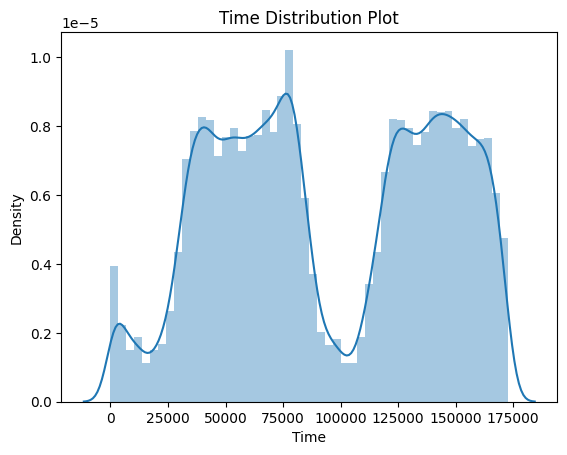

In [ ]:
sns.distplot(data["Time"])
plt.title("Time Distribution Plot")

##Scaling of Time and Amount

In [ ]:
data["Amount"].values

array([149.62,   2.69, 378.66, ...,  67.88,  10.  , 217.  ])

In [ ]:
data["Amount"].values.reshape(-1,1)

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [ ]:
rob_scaler = RobustScaler()
rob_scaler

RobustScaler()

In [ ]:
data["scaled_amount"] = rob_scaler.fit_transform(data["Amount"].values.reshape(-1,1))
data["scaled_amount"]

0         1.783274
1        -0.269825
2         4.983721
3         1.418291
4         0.670579
            ...   
284802   -0.296653
284803    0.038986
284804    0.641096
284805   -0.167680
284806    2.724796
Name: scaled_amount, Length: 284807, dtype: float64

In [ ]:
data["scaled_time"] = rob_scaler.fit_transform(data["Time"].values.reshape(-1,1))
data["scaled_time"]

0        -0.994983
1        -0.994983
2        -0.994972
3        -0.994972
4        -0.994960
            ...   
284802    1.034951
284803    1.034963
284804    1.034975
284805    1.034975
284806    1.035022
Name: scaled_time, Length: 284807, dtype: float64

In [ ]:
columns = ["Time", "Amount"]
data.drop(columns, inplace=True, axis=1)

In [ ]:
data.head()

,index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## Once scaled, we can have an overview of the correlation matrix.

In [ ]:
corrmat = data.corr()

<Axes: >

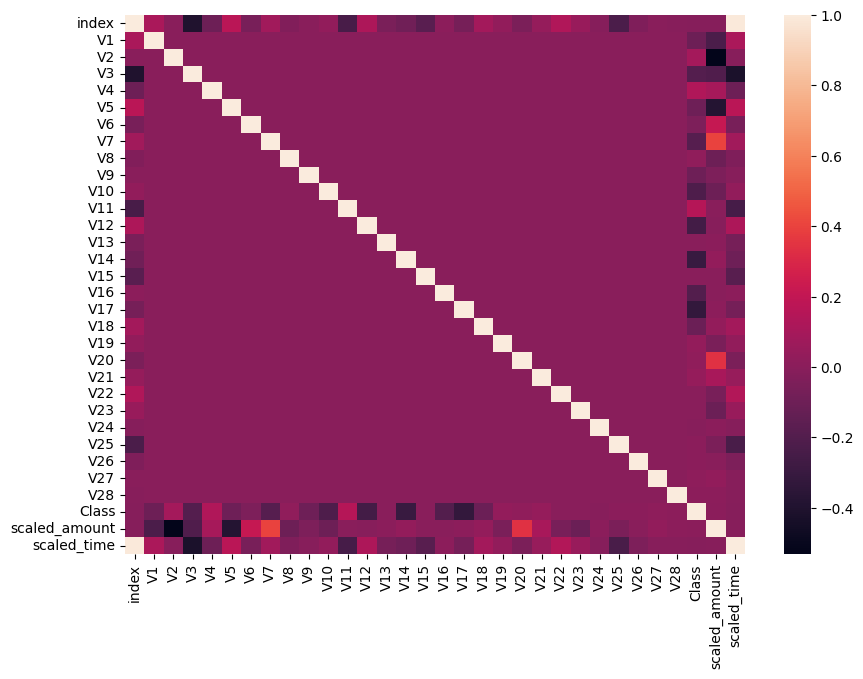

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(corrmat)

In [ ]:
corrmat["Class"]

index           -0.011692
V1              -0.101347
V2               0.091289
V3              -0.192961
V4               0.133447
V5              -0.094974
V6              -0.043643
V7              -0.187257
V8               0.019875
V9              -0.097733
V10             -0.216883
V11              0.154876
V12             -0.260593
V13             -0.004570
V14             -0.302544
V15             -0.004223
V16             -0.196539
V17             -0.326481
V18             -0.111485
V19              0.034783
V20              0.020090
V21              0.040413
V22              0.000805
V23             -0.002685
V24             -0.007221
V25              0.003308
V26              0.004455
V27              0.017580
V28              0.009536
Class            1.000000
scaled_amount    0.005632
scaled_time     -0.012323
Name: Class, dtype: float64

In [ ]:
corrmat.nlargest(6, "Class")["Class"][1:]

V11    0.154876
V4     0.133447
V2     0.091289
V21    0.040413
V19    0.034783
Name: Class, dtype: float64

In [ ]:
corrmat.nsmallest(5, "Class")["Class"]

V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
Name: Class, dtype: float64

V11, V4, V2, V21, V19 are positvely correlated.

V17, V14, V12, V10, V16 are negatively correlated.

## Stratified K Fold
Starified K Fold is a cross-validation technique that allows us to split dataset into individual folds while capturing the distribution of the original dataset. This is useful when dealing with imbalanced dataset, where 1 class is significantly more prevalent that the other.

By preserving the class distribution of each fold, this ensures that the distribution of data sampling for training and testing are a representative subset of the the original data.



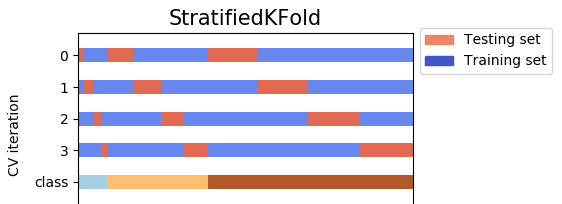


In [ ]:
data.drop("index", axis=1, inplace=True)

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [ ]:
X = data.drop("Class", axis =1)
y = data["Class"]

In [ ]:
X.shape

(284807, 30)

In [ ]:
y.shape

(284807,)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
skf.get_n_splits(x,y)

5

In [ ]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold {i}:")
  print(f"  Train: index={train_index}")
  print(f"  Test:  index={test_index}")
  original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
  original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Fold 0:
  Train: index=[     0      1      3 ... 284804 284805 284806]
  Test:  index=[     2     20     24 ... 284791 284793 284798]
Fold 1:
  Train: index=[     0      1      2 ... 284804 284805 284806]
  Test:  index=[     3      9     13 ... 284794 284799 284803]
Fold 2:
  Train: index=[     0      1      2 ... 284801 284802 284803]
  Test:  index=[    11     12     16 ... 284804 284805 284806]
Fold 3:
  Train: index=[     0      2      3 ... 284804 284805 284806]
  Test:  index=[     1      4      6 ... 284796 284801 284802]
Fold 4:
  Train: index=[     1      2      3 ... 284804 284805 284806]
  Test:  index=[     0      5      7 ... 284782 284790 284795]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


##Creating a sub dataframe of 50/50 fraud vs non fraud to identify optimal model. We will concat 492 non fraud and 492 fraud data to address the imbalance.

In [ ]:
#Shuffle the data
data = data.sample(frac=1)

In [ ]:
fraud = data.loc[data["Class"]==1]
non_fraud = data.loc[data["Class"]==0][:492]

sub_dataframe = pd.concat([fraud, non_fraud])

In [ ]:
sub_dataframe["Class"].value_counts()

Class
1    492
0    492
Name: count, dtype: int64

In [ ]:
sub_dataframe = sub_dataframe.sample(frac=1)

In [ ]:
sub_dataframe

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_amount,scaled_time
240780,240780,150749.0,-0.008466,0.729685,0.327337,-0.666830,0.311058,-0.880181,0.836402,-0.000399,...,0.085938,0.038373,-0.570828,0.118925,0.235366,0.085774,4.48,0,-0.244812,0.776055
29506,29506,35500.0,1.237944,0.230118,0.168591,0.507414,-0.233417,-0.579815,-0.087818,0.017894,...,0.087626,-0.068075,0.199305,0.100879,-0.033258,0.015100,0.89,0,-0.294977,-0.577920
83053,83053,59669.0,0.326007,1.286638,-2.007181,2.419675,-1.532902,-1.432803,-2.459530,0.617738,...,-0.174357,0.308061,0.710996,-0.231030,0.580495,0.300984,6.27,1,-0.219800,-0.293977
6719,6719,8415.0,-0.251471,4.313523,-6.891438,6.796797,0.616297,-2.966327,-2.436653,0.489328,...,-0.605240,-0.263743,1.539916,0.523574,0.891025,0.572741,1.00,1,-0.293440,-0.896122
203328,203328,134769.0,-0.967767,2.098019,-5.222929,6.514573,-4.187674,2.114178,0.948701,-2.448427,...,1.314312,-0.352887,-1.770706,0.098133,0.956769,0.162777,925.31,1,12.622232,0.588318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235644,235644,148479.0,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,...,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68,1,1.406833,0.749386
278092,278092,168034.0,-0.124256,1.108506,-0.637831,-0.797338,1.160724,-0.263981,0.808923,0.101210,...,0.057284,0.112186,-0.367159,0.127059,0.323954,0.136990,1.29,0,-0.289387,0.979123
70726,70726,53991.0,-2.215731,1.563442,0.942873,1.528802,-1.484600,0.749257,-1.020955,1.745993,...,-0.040884,-0.000891,0.185651,-0.382002,0.291483,0.056856,37.49,0,0.216447,-0.360683
263080,263080,160791.0,2.132386,0.705608,-3.530759,0.514779,1.527175,-1.716268,1.132791,-0.574214,...,-0.245076,0.460049,0.920281,-0.216586,-0.026219,-0.025001,1.00,1,-0.293440,0.894031


In [ ]:
def scatter(arg1,arg2):
  fig, ax = plt.subplots(figsize=(5,6))
  sns.scatterplot(data=data,x=arg1,y=arg2,hue="Class",alpha=0.8)
  plt.title(arg2 + " against " + arg1)

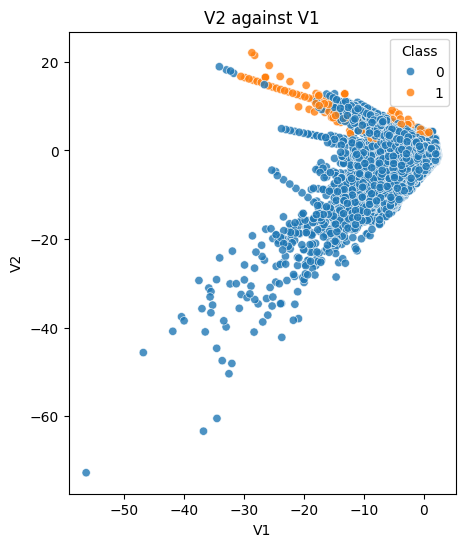

In [ ]:
scatter("V1","V2")

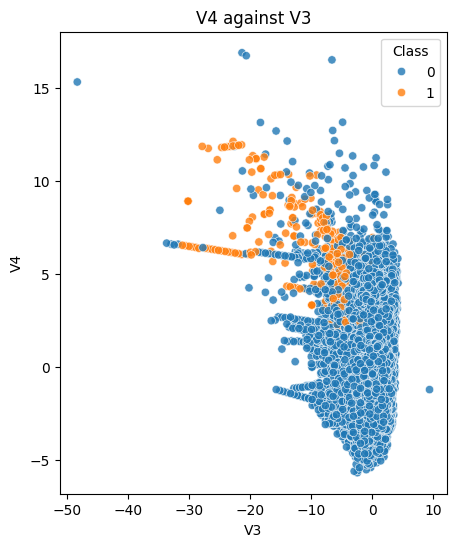

In [ ]:
scatter("V3","V4")

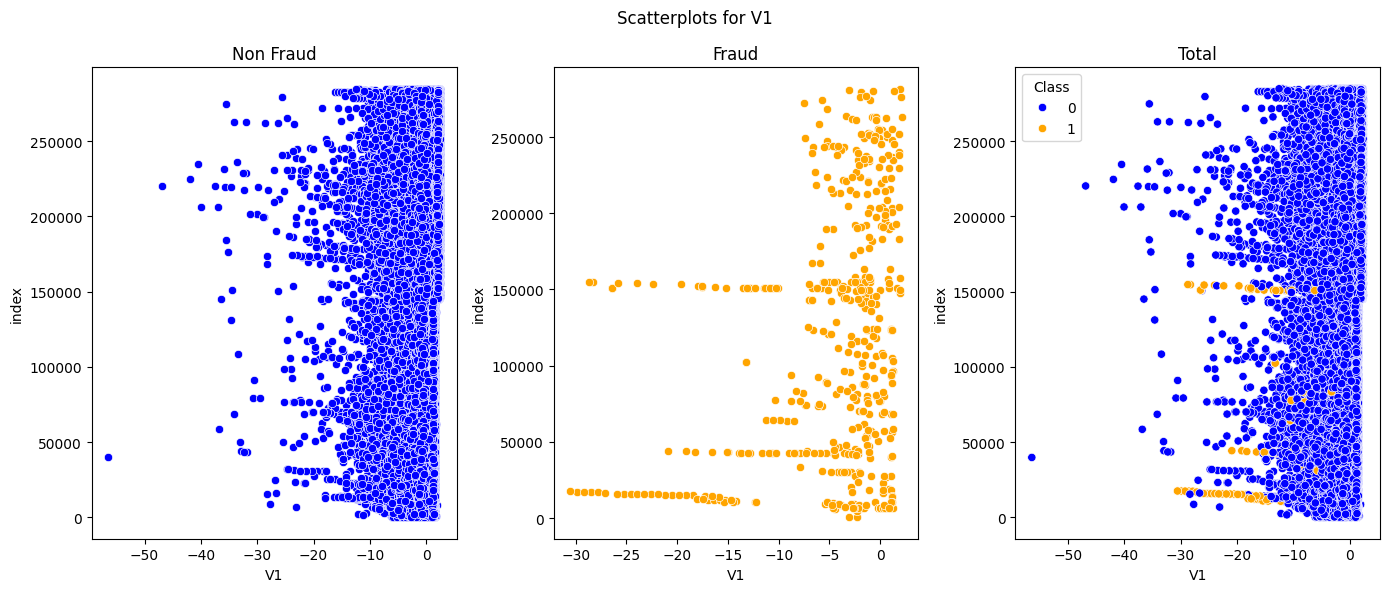

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(14,6))
sns.scatterplot(data=data[data["Class"]==0],x="V1",y="index",ax=axes[0],color='blue')
axes[0].set_title("Non Fraud")

sns.scatterplot(data=data[data["Class"]==1],x="V1",y="index",ax=axes[1],color='orange')
axes[1].set_title("Fraud")

sns.scatterplot(data=data,x="V1",y="index",ax=axes[2],hue="Class",palette=['blue', 'orange'])
axes[2].set_title("Total")

fig.suptitle('Scatterplots for V1')
plt.tight_layout()
plt.show()

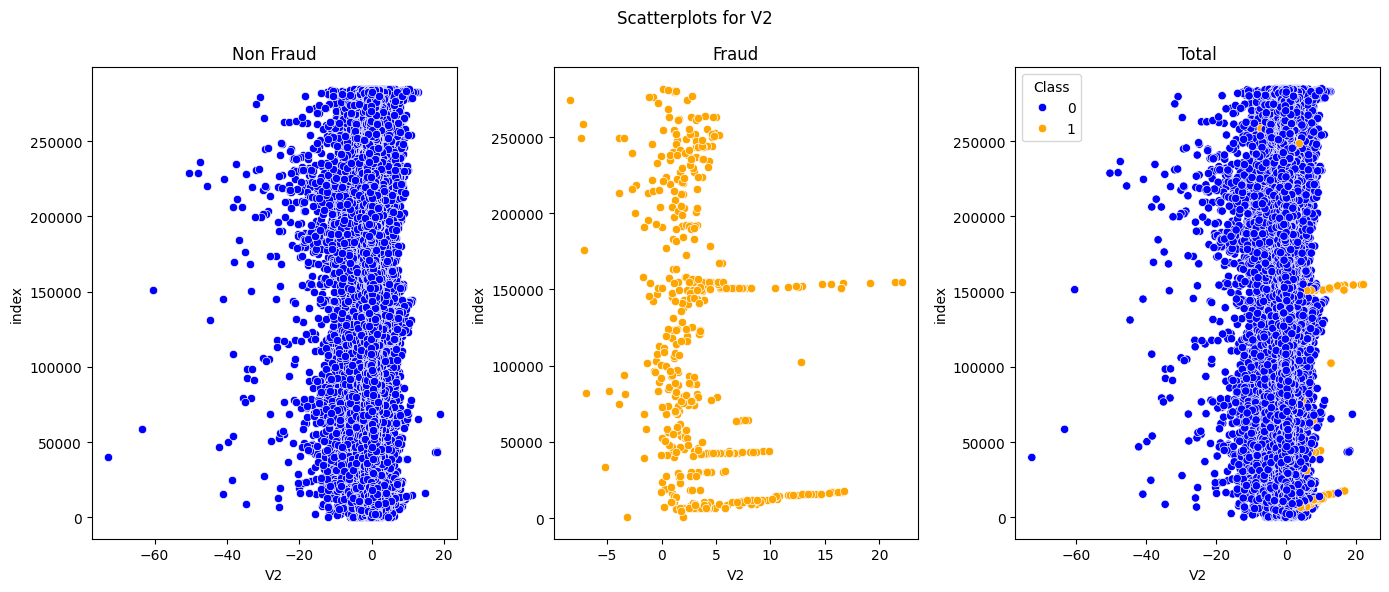

In [ ]:
fig,axes = plt.subplots(1,3,figsize=(14,6))
sns.scatterplot(data=data[data["Class"]==0],x="V2",y="index",ax=axes[0],color='blue')
axes[0].set_title("Non Fraud")

sns.scatterplot(data=data[data["Class"]==1],x="V2",y="index",ax=axes[1],color='orange')
axes[1].set_title("Fraud")

sns.scatterplot(data=data,x="V2",y="index",ax=axes[2],hue="Class",palette=['blue', 'orange'])
axes[2].set_title("Total")

fig.suptitle('Scatterplots for V2')
plt.tight_layout()
plt.show()

<Axes: xlabel='V1', ylabel='Amount'>

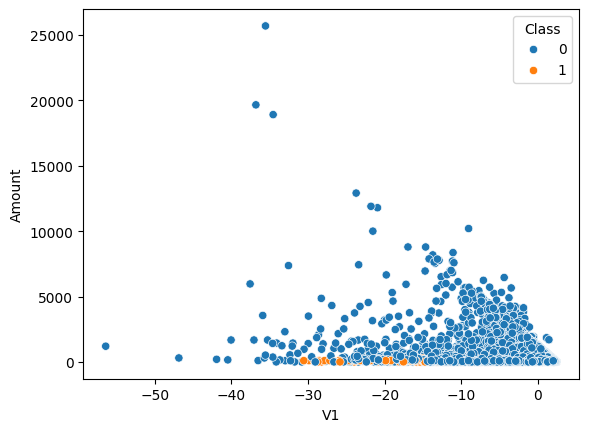

In [ ]:
sns.scatterplot(data=data,x="V1",y="Amount",hue="Class")

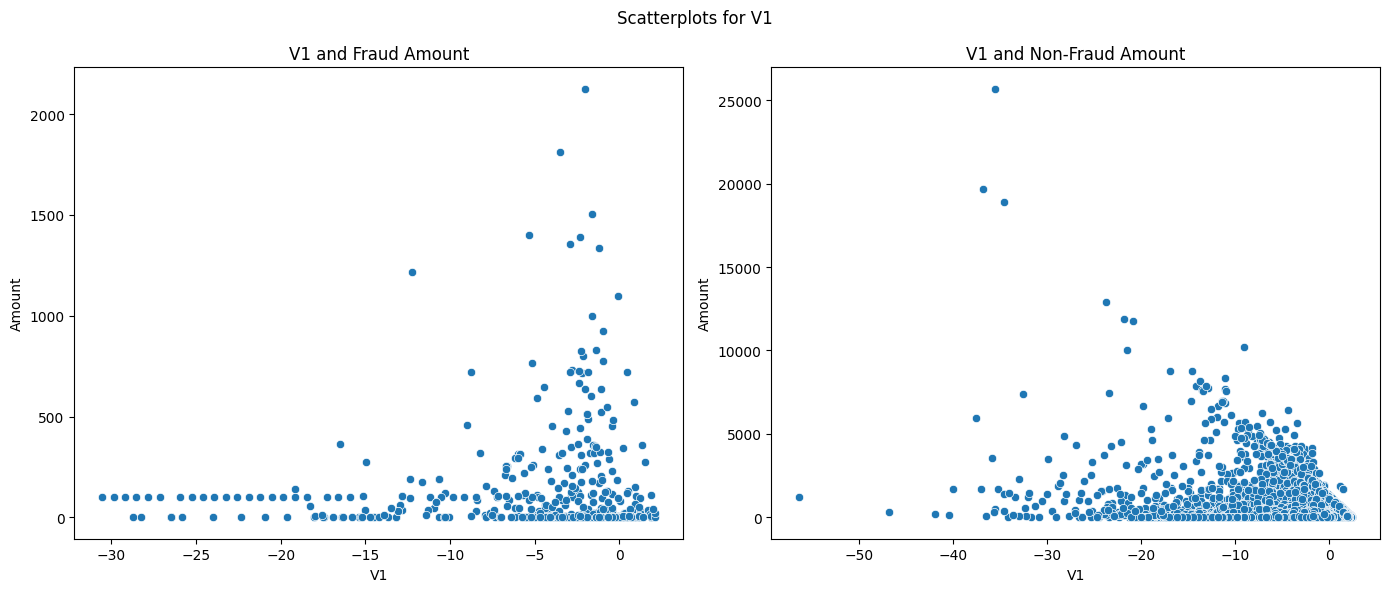

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,6))

sns.scatterplot(data=fraud_data,x="V1",y="Amount",ax=axes[0])
axes[0].set_title("V1 and Fraud Amount")

sns.scatterplot(non_fraud_data,x="V1",y="Amount", ax=axes[1])
axes[1].set_title("V1 and Non-Fraud Amount")

fig.suptitle('Scatterplots for V1')
plt.tight_layout()
plt.show()

In [ ]:
print("Non Fraud & Fraud mean")
stat.mean(non_fraud_data["Amount"]), stat.mean(fraud_data["Amount"])

Non Fraud & Fraud mean


(88.29102242231328, 122.21132113821139)

In [ ]:
print("Non Fraud & Fraudstandard deviation")
stat.stdev(non_fraud_data["Amount"]), stat.stdev(fraud_data["Amount"])

Non Fraud & Fraudstandard deviation


(250.10509222589243, 256.6832882977121)

<Axes: xlabel='V1'>

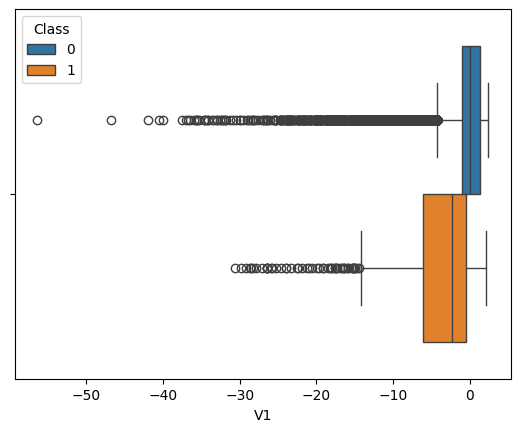

In [ ]:
sns.boxplot(data=data,x="V1",hue="Class")

In [ ]:
fraud_data

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


<Axes: xlabel='Amount', ylabel='Count'>

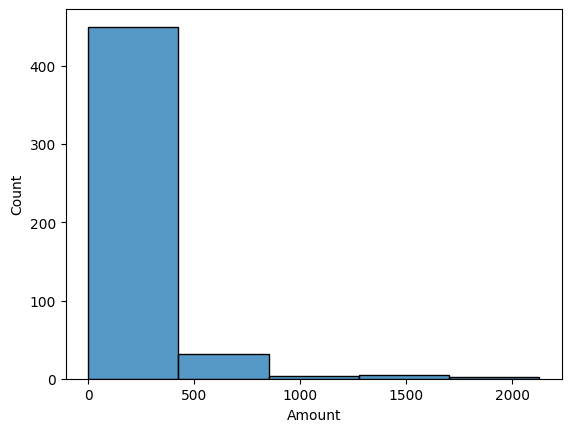

In [ ]:
sns.histplot(data=fraud_data,x="Amount",bins=5)

In [ ]:
"""
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = gb_classifier.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

SyntaxError: incomplete input (<ipython-input-37-cd94e3bbacb7>, line 1)

In [ ]:
"""
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

SyntaxError: incomplete input (<ipython-input-1-6aae7d5b753d>, line 1)